

    Implement a neural network based DQN with experience reply and compare its performance with the table based q learning algorithm you implemented in the last homework for two gym environments.

    You may use the same games as in your previous homework; you can also try a harder game this time.

    You don't need to tune the hyperparameters for training the neural network. But you need to train them with sufficient time.

    You may work in groups of 2.

    Turn in your report with the comparison of results between neural network based and table based q learning implementations.




In [ ]:
#collect all imports

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

In [ ]:
#Making the simple Neural Network for our DQN
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

NameError: name 'nn' is not defined

In [ ]:
# Colab helped me make the replay buffer and the DQN agent below. Very helpful, I would've taken a lot longer to get the device, optimizer, and criterion stuff down.
# It also reminded me to implement the learning decay so it doesn't remain constantly random. That was a good tip.
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)

    def __len__(self):
        return len(self.buffer)

In [ ]:
class DQNAgent:
    def __init__(self, env, obs_shape, learning_rate=0.001, gamma=0.99, buffer_capacity=10000, batch_size=64, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.env = env
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.buffer = ReplayBuffer(buffer_capacity)
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DQN(obs_shape, env.action_space.n).to(self.device)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return self.env.action_space.sample()
        state = torch.FloatTensor(state).to(self.device)
        q_values = self.model(state)
        return np.argmax(q_values.cpu().detach().numpy())

    def learn(self):
        # If we don't have enough of a past, we won't learn anything
        if len(self.buffer) < self.batch_size:
            return

        #get 64 random samples of how things were in the past from the buffer
        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        #get the q_values based on the 64 states retrieved from the buffer
        q_values = self.model(states)
        next_q_values = self.model(next_states)

        #grab one of the q_values
        q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        #grab one of the max next q-values
        next_q_value = next_q_values.max(1)[0]
        expected_q_value = rewards + self.gamma * next_q_value * (1 - dones)

        #compare and optimize
        loss = self.criterion(q_value, expected_q_value)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
          # Start random, and get progressively less random as you learn.
          # Thinking about it, this could also be in act, but then I'd have to put it in there twice. Better here.
            self.epsilon *= self.epsilon_decay

In [ ]:
env = gym.make('CartPole-v1')
agent = DQNAgent(env, env.observation_space.shape[0])

num_episodes = 10000

print("Running 10,000 episodes to train on cartpole. Printing the results from every 50th episode")

scores = np.array([])

for episode in range(1, num_episodes+1):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.buffer.push(state, action, reward, next_state, done)
        agent.learn()
        state = next_state
        total_reward += reward

    if episode % 50 == 0:
      print(f"Episode: {episode}, Total Reward: {total_reward}")
      scores = np.append(scores, total_reward)

env.close()

print(f"Scores:\n {scores}")

Running 10,000 episodes to train on cartpole. Printing the results from every 50th episode
Episode: 50, Total Reward: 9.0
Episode: 100, Total Reward: 41.0
Episode: 150, Total Reward: 9.0
Episode: 200, Total Reward: 14.0
Episode: 250, Total Reward: 39.0
Episode: 300, Total Reward: 26.0
Episode: 350, Total Reward: 38.0
Episode: 400, Total Reward: 23.0
Episode: 450, Total Reward: 22.0
Episode: 500, Total Reward: 13.0
Episode: 550, Total Reward: 22.0
Episode: 600, Total Reward: 32.0
Episode: 650, Total Reward: 44.0
Episode: 700, Total Reward: 39.0
Episode: 750, Total Reward: 29.0
Episode: 800, Total Reward: 40.0
Episode: 850, Total Reward: 27.0
Episode: 900, Total Reward: 41.0
Episode: 950, Total Reward: 81.0
Episode: 1000, Total Reward: 57.0
Episode: 1050, Total Reward: 52.0
Episode: 1100, Total Reward: 52.0
Episode: 1150, Total Reward: 83.0
Episode: 1200, Total Reward: 64.0
Episode: 1250, Total Reward: 58.0
Episode: 1300, Total Reward: 55.0
Episode: 1350, Total Reward: 85.0
Episode: 1400

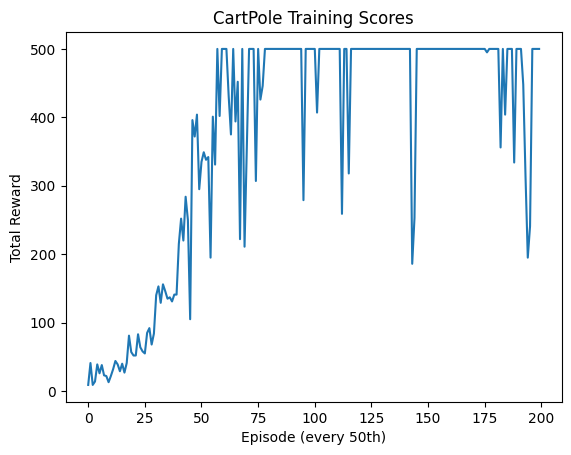

In [ ]:
import matplotlib.pyplot as plt


plt.plot(scores)
plt.xlabel("Episode (every 50th)")
plt.ylabel("Total Reward")
plt.title("CartPole Training Scores")
plt.show()

In [ ]:
env = gym.make('CartPole-v1')

num_runs = 1000
total_scores = 0

for run in range(num_runs):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
    total_scores += total_reward

average_score = total_scores / num_runs
print(f"Average score over {num_runs} runs: {average_score}")

env.close()

Average score over 1000 runs: 193.757


# Cartpole Scores Analysis

After training this for 3 hours or so I'm mainly interested in the fact that the agent still seems to be so inconsistent when getting the average score. It seems that from the training graph, the agent quickly is able to get to the max possible score, but when it messes up it messes up early.

The weird thing is if we take the average of the scores we looked at as the agent was training, we get an average of 376.715 after summing up those 200 scores. \
I would think that we got very lucky with our scores every 50th episode, but that distribution is similar to what I got when I've run the agent before. I'm puzzled, and I'll ask about it in class later.

Compared to the top 3 scores with QTABLE and SARSA:\
SARSA: Learning Rate = 0.9, Discount Factor = 0.1, Exploration Rate = 0.5 - Average Score: 32.74\
SARSA: Learning Rate = 0.1, Discount Factor = 0.9, Exploration Rate = 0.1 - Average Score: 30.54\
QTable: Learning Rate = 0.9, Discount Factor = 0.5, Exploration Rate = 0.1 - Average Score: 25.99

Our current average of 193.757 is much much better. It isn't always hitting the max, but it is actually surviving after the first 3 seconds. So at the very least, our DQN is able to remember more states of being and act appropriately.

In [ ]:
env = gym.make('Blackjack-v1')
agent = DQNAgent(env, 3)

print("Running 2,000,000 episodes to train on blackjack. Printing the results from every 1000th episode")

#Blackjack actually runs much faster than cartpole, so I'll run this for 1000 times the length of cartpole
num_episodes = 2000000

num_wins = 0
num_losses = 0
num_draws = 0
b_scores = np.array([])

for episode in range(1, num_episodes+1):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.buffer.push(state, action, reward, next_state, done)
        agent.learn()
        state = next_state
        total_reward += reward

    if total_reward > 0:
      num_wins += 1
    elif total_reward < 0:
      num_losses += 1
    else:
      num_draws += 1

    if episode % 1000 == 0:
      print(f"Episode: {episode}, Total Reward: {total_reward}")
      b_scores = np.append(b_scores, total_reward)

env.close()

print(f"Scores:\n {b_scores}")
print(f"Percent Wins: {(num_wins/num_episodes)*100}\nPercent Losses: {(num_losses/num_episodes)*100}\nPercent Draws: {(num_draws/num_episodes)*100}")

Running 2,000,000 episodes to train on blackjack. Printing the results from every 1000th episode
Episode: 1000, Total Reward: 1.0
Episode: 2000, Total Reward: -1.0
Episode: 3000, Total Reward: 1.0
Episode: 4000, Total Reward: 1.0
Episode: 5000, Total Reward: 0.0
Episode: 6000, Total Reward: -1.0
Episode: 7000, Total Reward: -1.0
Episode: 8000, Total Reward: 1.0
Episode: 9000, Total Reward: 0.0
Episode: 10000, Total Reward: -1.0
Episode: 11000, Total Reward: -1.0
Episode: 12000, Total Reward: 1.0
Episode: 13000, Total Reward: 1.0
Episode: 14000, Total Reward: -1.0
Episode: 15000, Total Reward: 1.0
Episode: 16000, Total Reward: 0.0
Episode: 17000, Total Reward: 1.0
Episode: 18000, Total Reward: -1.0
Episode: 19000, Total Reward: -1.0
Episode: 20000, Total Reward: 1.0
Episode: 21000, Total Reward: -1.0
Episode: 22000, Total Reward: -1.0
Episode: 23000, Total Reward: 1.0
Episode: 24000, Total Reward: -1.0
Episode: 25000, Total Reward: -1.0
Episode: 26000, Total Reward: -1.0
Episode: 27000,

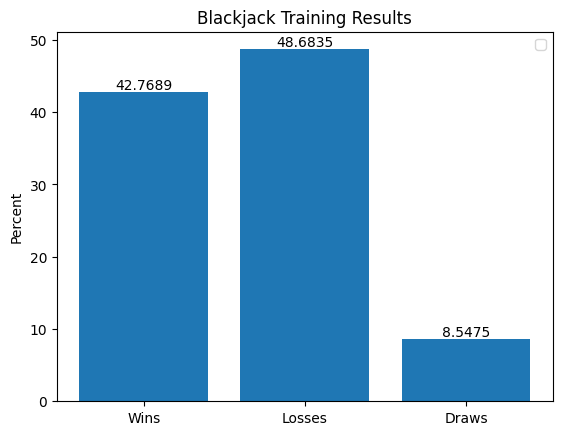

In [ ]:
import matplotlib.pyplot as plt

per_wins = (num_wins/num_episodes)*100
per_losses = (num_losses/num_episodes)*100
per_draws = (num_draws/num_episodes)*100

plt.bar(["Wins", "Losses", "Draws"], [per_wins, per_losses, per_draws])
plt.bar_label(plt.gca().containers[0])
plt.ylabel("Percent")
plt.title("Blackjack Training Results")
plt.legend()
plt.show()

Average Wins: 42.10%
Average Losses: 48.10%
Average Draws: 9.80%


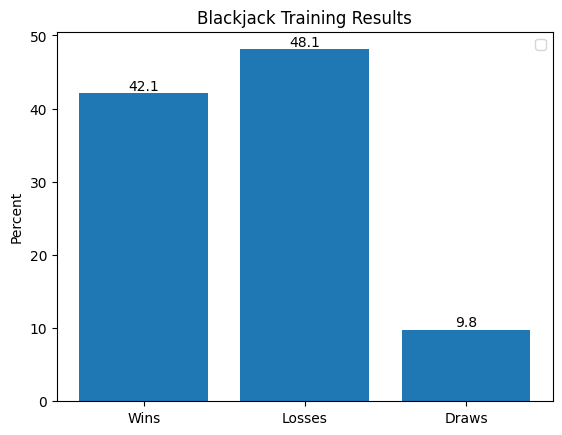

In [ ]:

env = gym.make('Blackjack-v1')

total_wins = 0
total_losses = 0
total_draws = 0

#running the trained agent 1000 times to see its average scores
for _ in range(1000):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward

    if total_reward > 0:
        total_wins += 1
    elif total_reward < 0:
        total_losses += 1
    else:
        total_draws += 1

env.close()

avg_wins = (total_wins / 1000)*100
avg_losses = (total_losses / 1000)*100
avg_draws = (total_draws / 1000)*100



print(f"Average Wins: {avg_wins:.2f}%")
print(f"Average Losses: {avg_losses:.2f}%")
print(f"Average Draws: {avg_draws:.2f}%")

plt.bar(["Wins", "Losses", "Draws"], [avg_wins, avg_losses, avg_draws])
plt.bar_label(plt.gca().containers[0])
plt.ylabel("Percent")
plt.title("Blackjack Training Results")
plt.legend()
plt.show()

# Blackjack Scores Analysis


Only took 2 hours and some odd minutes for 2,000,000 episodes. Neat!


The graph above should be called Blackjack results, but I forgot to change the name earlier and I don't want to run the whole thing again just to fix that.

The score for Q-table and SARSA after training were:

SARSA/QTABLE: Learning Rate = 0.1, Discount Factor = 0.1, Exploration Rate = 0.1 - Average Score: -0.069

Converting the scores into something we can understand for the Q-table and SARSA implementation:

* An average score of 1 would mean it always wins
* An average score of 0 means it always draws
* An average score of -1 means it always loses

The best score the Q-table/SARSA implementation got was -0.069, which is best explained as 431 wins for every 569 losses. (Draws don't move the average, so we can't tell how many there were.).

For our average run on the DQN blackjack agent, we got 421 wins, 481 losses, and 98 draws.\
(We can calculate this since our percentages are just `the number/10`)\
That gets us an average score of -0.06, meaning the DQN does a little better than our Qtable.

There could be a multitude of reasons for that, but I think its due to blackjack being strategically simple and chance based.\
At certain points, there is only one right answer. Its either impossible to bust, possible to bust, or very likely to bust.

Once the agent learns how to deal with those situations, everything else is out of its control. It might improve more if I somehow taught it to count cards, but I don't think that information is part of the blackjack environment for me to train with.

At the very least, the DQN agent was able to reduce its losses by around 8.7%.
